# 0. Module loading

In [1]:
import os,pandas,dill,datetime,time,numpy
import matplotlib,matplotlib.pyplot
import miner
%matplotlib inline

# 0.1. User defined paths

In [10]:
# 0. user defined variables
inputDataFile='/Volumes/omics4tb2/alomana/projects/PSL/GBM/results/normalization/QN.MA.data.csv'
resultsDirectory='/Volumes/omics4tb2/alomana/projects/PSL/GBM/results/MINER/'
if not os.path.isdir(outputDir):
    os.mkdir(outputDir)

# 1. Read data

In [11]:
expressionData=pandas.read_csv(inputDataFile,header=0,index_col=0,sep=",")
print 'expression data shape',expressionData.shape
expressionData,conversionTable=miner.identifierConversion(expressionData)

expression data shape (11312, 538)
completed identifier conversion.
10663 genes were converted.


# 2. Transform data

In [12]:
expressionData=miner.zscore(expressionData)

completed z-transformation.


# 3. Network inference

## 3.0. Set parameters

In [13]:
# minimum number of genes that form an acceptable coexpression cluster:
minNumberGenes = 6 #bulk RNAseq default=6;single cell RNAseq default=6

# minimum correlation coefficient for an acceptable regulator-cluster association 
minCorrelation = 0.2 #bulk RNAseq default=0.2;single cell RNAseq default=0.05

# minimum number of genes that form an acceptable coexpression cluster and have share binding site for regulator:
minNumberRegulonGenes = 5 #bulk RNAseq default=5;single cell RNAseq default=4

# choose database: if supplying your own database, use mechanistic_database = reference_mechanistic_database
mechanistic_database = "tfbsdb_tf_to_genes.pkl" #default option
#mechanistic_database = reference_mechanistic_database #use if supplying your own database

# number of cores available for multiprocessing
numCores = 8

## 3.1. Co-expression clustering

2019-04-30 12:10:44
0.00 percent complete
20.00 percent complete
40.00 percent complete
60.00 percent complete
80.00 percent complete

coexpression clustering completed in 16.09 minutes
Number of genes clustered: 10003
Number of unique clusters: 804
Completed clustering module in 16.50 minutes
2019-04-30 12:27:14


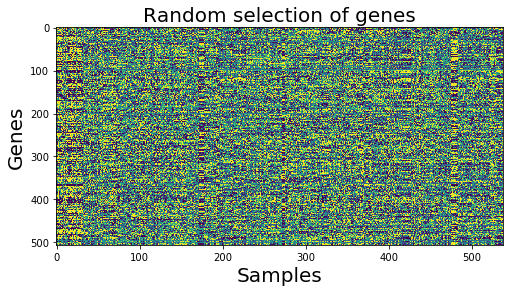

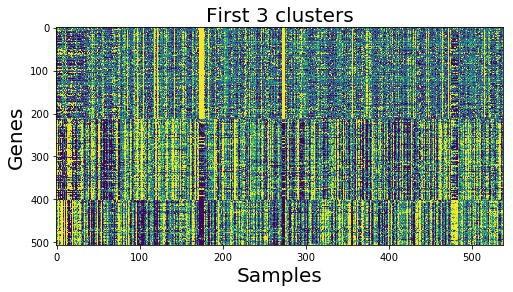

In [15]:
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
t1 = time.time()
# generate a list of coexpressed gene clusters, all of which have length >= minNumberGenes
initialClusters = miner.cluster(expressionData,minNumberGenes = minNumberGenes,minNumberOverExpSamples=4,maxSamplesExcluded=0.50,random_state=12,overExpressionThreshold=80) 
# revise initialClusters to combine highly correlated clusters and keep only those with significant coexpression
revisedClusters = miner.reviseInitialClusters(initialClusters,expressionData)
# write revisedClusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary.json"))
# ensure that keys have type str

# retrieve first three clusters for visual inspection
first_clusters = numpy.hstack([revisedClusters[i] for i in numpy.arange(3).astype(str)])

# visualize background expression
matplotlib.pyplot.figure(figsize=(8,4))
matplotlib.pyplot.imshow(expressionData.loc[numpy.random.choice(expressionData.index,len(first_clusters),replace=False),:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
matplotlib.pyplot.grid(False)
matplotlib.pyplot.ylabel("Genes",FontSize=20)
matplotlib.pyplot.xlabel("Samples",FontSize=20)
matplotlib.pyplot.title("Random selection of genes",FontSize=20)

# visualize first 10 clusters
matplotlib.pyplot.figure(figsize=(8,4))
matplotlib.pyplot.imshow(expressionData.loc[first_clusters,:],aspect="auto",cmap="viridis",vmin=-1,vmax=1)
matplotlib.pyplot.grid(False)
matplotlib.pyplot.ylabel("Genes",FontSize=20)
matplotlib.pyplot.xlabel("Samples",FontSize=20)
matplotlib.pyplot.title("First 3 clusters",FontSize=20)

# report coverage
print("Number of genes clustered: {:d}".format(len(set(numpy.hstack(initialClusters)))))
print("Number of unique clusters: {:d}".format(len(revisedClusters)))

t2 = time.time()
print("Completed clustering module in {:.2f} minutes".format((t2-t1)/60.))
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

## 3.2. Mechanistic inference

In [17]:
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
t1 = time.time()
# get first principal component axes of clusters
axes = miner.principalDf(revisedClusters,expressionData,subkey=None,minNumberGenes=1)
# analyze revised clusters for enrichment in relational database (default: transcription factor binding site database)
mechanisticOutput = miner.mechanisticInference(axes,revisedClusters,expressionData,correlationThreshold=minCorrelation,numCores=numCores,database=mechanistic_database)
# write mechanistic output to .json file
miner.write_json(mechanisticOutput,os.path.join(resultsDirectory,"mechanisticOutput.json"))
# order mechanisticOutput as {tf:{coexpressionModule:genes}} 
coregulationModules = miner.getCoregulationModules(mechanisticOutput)
# write coregulation modules to .json file
miner.write_json(coregulationModules,os.path.join(resultsDirectory,"coregulationModules.json"))
# get final regulons by keeping genes that requently appear coexpressed and associated to a common regulator
regulons = miner.getRegulons(coregulationModules,minNumberGenes=minNumberRegulonGenes,freqThreshold = 0.333)
# reformat regulon dictionary for consistency with revisedClusters and coexpressionModules
regulonModules, regulonDf = miner.regulonDictionary(regulons)
# write regulonDf to csv using preferred gene name identifiers
regulonDf.to_csv(os.path.join(resultsDirectory,"regulonDf.csv"))
# write regulons to json file
miner.write_json(regulonModules,os.path.join(resultsDirectory,"regulons.json"))
# define coexpression modules as composite of coexpressed regulons
coexpressionModules = miner.getCoexpressionModules(mechanisticOutput)
# write coexpression modules to .json file
miner.write_json(coexpressionModules,os.path.join(resultsDirectory,"coexpressionModules.json"))
#reconvert revised clusters to original gene annotations
annotatedRevisedClusters = miner.convertDictionary(revisedClusters,conversionTable)
# write annotated coexpression clusters to .json file
miner.write_json(revisedClusters,os.path.join(resultsDirectory,"coexpressionDictionary_annotated.json"))
#reconvert results into original annotations
regulonAnnotatedDf = miner.convertRegulons(regulonDf,conversionTable)
#write annotated regulon table to .csv
regulonAnnotatedDf.to_csv(os.path.join(resultsDirectory,"regulons_annotated.csv"))
#reconvert regulons
annotatedRegulons = miner.convertDictionary(regulonModules,conversionTable)
# write annotated regulons to .json file
miner.write_json(annotatedRegulons,os.path.join(resultsDirectory,"regulons_annotated.json"))
#reconvert coexpression modules
annotatedCoexpressionModules = miner.convertDictionary(coexpressionModules,conversionTable)
# write annotated coexpression modules to .json file
miner.write_json(annotatedCoexpressionModules,os.path.join(resultsDirectory,"coexpressionModules_annotated.json"))
t2 = time.time()
print("Completed mechanistic inference in {:.2f} minutes".format((t2-t1)/60.))
print("Inferred network with {:d} regulons, {:d} regulators, and {:d} co-regulated genes".format(len(regulonDf.Regulon_ID.unique()),len(regulonDf.Regulator.unique()),len(regulonDf.Gene.unique())))
print datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")

2019-04-30 15:15:03
Running mechanistic inference
Completed mechanistic inference in 3.40 minutes
Inferred network with 2796 regulons, 404 regulators, and 6351 co-regulated genes
2019-04-30 15:18:27


## 3.3. Causal inference

## 3.4. Network mapping